### Multi-variable RNN Prediction 
* code reference https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/ 

In [2]:
!wget -O raw.csv https://raw.githubusercontent.com/jbrownlee/Datasets/master/pollution.csv 

--2020-11-18 06:40:44--  https://raw.githubusercontent.com/jbrownlee/Datasets/master/pollution.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.200.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.200.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2010492 (1.9M) [text/plain]
Saving to: ‘raw.csv’

raw.csv             100%[===================>]   1.92M  --.-KB/s    in 0.02s   

2020-11-18 06:40:44 (114 MB/s) - ‘raw.csv’ saved [2010492/2010492]



In [1]:
from pandas import read_csv
from datetime import datetime
# load data
def parse(x):
    return datetime.strptime(x, '%Y %m %d %H')
dataset = read_csv('raw.csv',  parse_dates = [['year', 'month', 'day', 'hour']], index_col=0, date_parser=parse)
dataset.drop('No', axis=1, inplace=True)
# manually specify column names
dataset.columns = ['pollution', 'dew', 'temp', 'press', 'wnd_dir', 'wnd_spd', 'snow', 'rain']
dataset.index.name = 'date'
# mark all NA values with 0
dataset['pollution'].fillna(0, inplace=True)
# drop the first 24 hours
dataset = dataset[24:]
# summarize first 5 rows
print(dataset.head(5))
# save to file
dataset.to_csv('pollution.csv')

                     pollution  dew  temp   press wnd_dir  wnd_spd  snow  rain
date                                                                          
2010-01-02 00:00:00      129.0  -16  -4.0  1020.0      SE     1.79     0     0
2010-01-02 01:00:00      148.0  -15  -4.0  1020.0      SE     2.68     0     0
2010-01-02 02:00:00      159.0  -11  -5.0  1021.0      SE     3.57     0     0
2010-01-02 03:00:00      181.0   -7  -5.0  1022.0      SE     5.36     1     0
2010-01-02 04:00:00      138.0   -7  -5.0  1022.0      SE     6.25     2     0


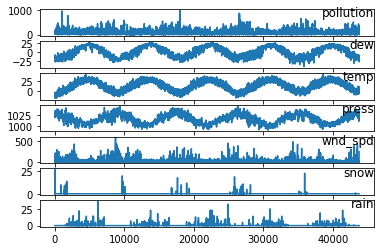

In [2]:
from pandas import read_csv
from matplotlib import pyplot
# load dataset
dataset = read_csv('pollution.csv', header=0, index_col=0)
values = dataset.values
# specify columns to plot
groups = [0, 1, 2, 3, 5, 6, 7]
i = 1
# plot each column
pyplot.figure()
for group in groups:
	pyplot.subplot(len(groups), 1, i)
	pyplot.plot(values[:, group])
	pyplot.title(dataset.columns[group], y=0.5, loc='right')
	i += 1
pyplot.show()

In [9]:
# prepare data for lstm
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

# convert series to supervised learning
def series_to_supervised(data, n_in=12, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

# load dataset
dataset = read_csv('pollution.csv', header=0, index_col=0)
values = dataset.values
# integer encode direction
encoder = LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 12, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)
print(reframed.head())

    var1(t-12)  var2(t-12)  var3(t-12)  var4(t-12)  var5(t-12)  var6(t-12)  \
12    0.129779    0.352941    0.245902    0.527273    0.666667    0.002290   
13    0.148893    0.367647    0.245902    0.527273    0.666667    0.003811   
14    0.159960    0.426471    0.229508    0.545454    0.666667    0.005332   
15    0.182093    0.485294    0.229508    0.563637    0.666667    0.008391   
16    0.138833    0.485294    0.229508    0.563637    0.666667    0.009912   

    var7(t-12)  var8(t-12)  var1(t-11)  var1(t-10)  ...  var7(t-1)  var8(t-1)  \
12    0.000000         0.0    0.148893    0.159960  ...        0.0        0.0   
13    0.000000         0.0    0.159960    0.182093  ...        0.0        0.0   
14    0.000000         0.0    0.182093    0.138833  ...        0.0        0.0   
15    0.037037         0.0    0.138833    0.109658  ...        0.0        0.0   
16    0.074074         0.0    0.109658    0.105634  ...        0.0        0.0   

     var1(t)   var2(t)   var3(t)   var4(t)  

In [10]:
# split into train and test sets
values = reframed.values
n_train_hours = 365 * 24
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0],  train_X.shape[1], 1))
test_X = test_X.reshape((test_X.shape[0],  test_X.shape[1], 1))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(8760, 96, 1) (8760,) (35028, 96, 1) (35028,)


In [11]:
pip install tensorflow==2.2.0 

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/tensorflow2_p36/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


Epoch 1/50
122/122 - 6s - loss: 0.0130 - val_loss: 0.0064
Epoch 2/50
122/122 - 5s - loss: 0.0095 - val_loss: 0.0071
Epoch 3/50
122/122 - 5s - loss: 0.0090 - val_loss: 0.0066
Epoch 4/50
122/122 - 5s - loss: 0.0085 - val_loss: 0.0067
Epoch 5/50
122/122 - 5s - loss: 0.0083 - val_loss: 0.0062
Epoch 6/50
122/122 - 5s - loss: 0.0082 - val_loss: 0.0060
Epoch 7/50
122/122 - 6s - loss: 0.0082 - val_loss: 0.0054
Epoch 8/50
122/122 - 6s - loss: 0.0083 - val_loss: 0.0051
Epoch 9/50
122/122 - 6s - loss: 0.0080 - val_loss: 0.0060
Epoch 10/50
122/122 - 5s - loss: 0.0082 - val_loss: 0.0051
Epoch 11/50
122/122 - 6s - loss: 0.0080 - val_loss: 0.0052
Epoch 12/50
122/122 - 5s - loss: 0.0081 - val_loss: 0.0055
Epoch 13/50
122/122 - 5s - loss: 0.0080 - val_loss: 0.0051
Epoch 14/50
122/122 - 5s - loss: 0.0083 - val_loss: 0.0065
Epoch 15/50
122/122 - 5s - loss: 0.0080 - val_loss: 0.0060
Epoch 16/50
122/122 - 5s - loss: 0.0079 - val_loss: 0.0062
Epoch 17/50
122/122 - 5s - loss: 0.0080 - val_loss: 0.0057
Epoch 

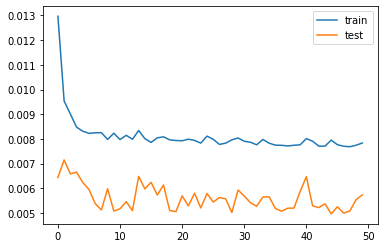

In [12]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# design network
model = keras.Sequential()
model.add(layers.LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(layers.Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)


# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()